# **Analyzing the effects of various factors on the significance/impactfulness of Earthquakes**
By: Mu Ye Liu and Edmund Chu

In [18]:
# Load required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


### **Brief insight about our analysis** 
##### **About the dataset**

The dataset we are using contains a sample 782 earthquakes of varying magnitudes recorded between Jan 1, 2002 to Jan 1, 2023. The data was provided by the USGS (United States Geological Survey), and is obtained via API requests. All earthquakes have their time, magnitude, shaking intensity, location, depth, etc, recorded. A description of all variables is listed below. Note that some entries have "NaN" for certain variables, which indicates missing/lost information from that entry.

##### **Goal and motivation of our analysis**

Many earthquakes happen every year. Not all are made equal. Some are minor and hardly felt, while others are disruptive, violent and devastating, resulting in billions of dollars in damage and social unrest. The main purpose of our analysis is to examine how important aspects of an earthquake, such as the magnitude, intensity, depth, and whether or not a tsunami was generated effect the impactfulness of an earthquake. Moreover, our goal is to also predict the potential impactfulness of a new earthquake based on given magnitude, intensity, etc parameters. This will give us an insight on how much damage will be caused by an earthquake if it were to occur in the future, allowing for further statistical exploration. This includes topics such as for example: how much the affected country's economy will be disrupted, how much funding should be allocated to recover from the earthquake disaster, model the number of casualties (injuries and deaths) that will likely result from the earthquake. 

Therefore, research question that will be further analyzed is: *Based on the magnitude, shaking intensity, depth of an earthquake, as well as whether or not a tsunami was triggered, how severe and impactful will that earthquake be?*

### **Load the Dataset**

In [19]:
# Load the data to analyze into the notebook
earthquake_data = pd.read_csv('earthquake data/earthquake_data.csv')
earthquake_data

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,"M 7.7 - 28 km SSW of Puerto El Triunfo, El Sal...",7.7,13-01-2001 17:33,0,8,NaN,0,912,us,427,0.000,0.0,mwc,60.000,13.0490,-88.660,"Puerto El Triunfo, El Salvador",NaN,NaN
778,"M 6.9 - 47 km S of Old Harbor, Alaska",6.9,10-01-2001 16:02,5,7,NaN,0,745,ak,0,0.000,0.0,mw,36.400,56.7744,-153.281,"Old Harbor, Alaska",North America,NaN
779,"M 7.1 - 16 km NE of Port-Olry, Vanuatu",7.1,09-01-2001 16:49,0,7,NaN,0,776,us,372,0.000,0.0,mwb,103.000,-14.9280,167.170,"Port-Olry, Vanuatu",NaN,Vanuatu
780,"M 6.8 - Mindanao, Philippines",6.8,01-01-2001 08:54,0,5,NaN,0,711,us,64,0.000,0.0,mwc,33.000,6.6310,126.899,"Mindanao, Philippines",NaN,NaN


### **Brief Description of Variables**

##### 1. **title:**  &nbsp;<span style="font-size: 16px;">Title or name given to the earthquake event.

##### 2. **magnitude:**  &nbsp;<span style="font-size: 16px;">The magnitude of the earthquake, measuring the energy released.

##### 3. **date_time:**  &nbsp;<span style="font-size: 16px;">Date and time of the earthquake occurrence.

##### 4. **cdi:**  &nbsp;<span style="font-size: 16px;">The maximum reported intensity for the event, based on community reports.

##### 5. **mmi:**  &nbsp;<span style="font-size: 16px;">Maximum estimated instrumental intensity (ground shaking) for the event.

##### 6. **alert:**  &nbsp;<span style="font-size: 16px;">Alert level categorized as “green”, “yellow”, “orange”, or “red.”

##### 7. **tsunami:**  &nbsp;<span style="font-size: 16px;">Binary indicator (1 = tsunami occurred, 0 = no tsunami).

##### 8. **sig:**  &nbsp;<span style="font-size: 16px;">A composite significance score indicating the overall impact of the event. A higher score indicates a more impactful, devastating earthquake

##### 9. **net:**  &nbsp;<span style="font-size: 16px;">ID of the data contributor network providing information on the event.

##### 10. **nst:**  &nbsp;<span style="font-size: 16px;">Total number of seismic stations used to determine the earthquake location.

##### 11. **dmin:**  &nbsp;<span style="font-size: 16px;">Horizontal distance from the epicenter to the nearest seismic station.

##### 12. **gap:**  &nbsp;<span style="font-size: 16px;">Largest azimuthal gap between seismic stations, measured in degrees.

##### 13. **magType:**  &nbsp;<span style="font-size: 16px;">Method or algorithm used to calculate the magnitude of the earthquake.

##### 14. **depth:**  &nbsp;<span style="font-size: 16px;">Depth at which the earthquake rupture begins, measured in kilometers.

##### 15. **latitude / longitude:**  &nbsp;<span style="font-size: 16px;">Geographic coordinates specifying the earthquake’s epicenter, recorded in degrees for both latitude and longitude. Negative Latitude indicates the southern hemisphere, negative Longitude indicates the west half of the world.

##### 16. **location:**  &nbsp;<span style="font-size: 16px;">Describes the earthquake’s location within a country.

##### 17. **continent:**  &nbsp;<span style="font-size: 16px;">Continent where the earthquake occurred.

##### 18. **country:**  &nbsp;<span style="font-size: 16px;">Country that was the most affected by the earthquake

### **Clean and filter the data to only use relevant variables**

The dataset that is used contains many variables (covariates). The goal of this analysis is to analyze and predict the impactfulness of an earthquake based on its magnitude, mmi shaking intensity, earthquake depth, and whether or not a tsunami was generated (whether or not it occurred under the ocean). Therefore, only the variables: **magnitude**, **mmi**, **tsunami**, **depth** and **sig** will be considered for the analysis, with all other variables omitted. The **sig** (or significance score) will be the response variable and simultaneously, the one we aim to predict based on given parameters.

In [20]:
# Select the columns that will be used our data analysis
earthquake_data_filtered = earthquake_data[['magnitude', 'mmi', 'tsunami', 'sig', 'depth']].round({'depth': 2})
earthquake_data_filtered

,magnitude,mmi,tsunami,sig,depth
0,7.0,7,1,768,14.00
1,6.9,4,0,735,25.00
2,7.0,3,1,755,579.00
3,7.3,5,1,833,37.00
4,6.6,2,1,670,624.46
...,...,...,...,...,...
777,7.7,8,0,912,60.00
778,6.9,7,0,745,36.40
779,7.1,7,0,776,103.00
780,6.8,5,0,711,33.00



### **Description of Variables Used in Analysis (More in depth)**

#### **1. Magnitude (magnitude)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Measures the energy released during an earthquake, represented on the Richter scale.  

**Relevance:**  
Larger magnitudes often lead to more damage and higher societal impact. This is a key predictor of risk, influencing structural damage and fatalities.

---

#### **2. Maximum Instrumental Intensity (mmi)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Represents the estimated intensity of ground shaking experienced during the earthquake.  

**Relevance:**  
Higher intensity values correspond to stronger ground motion, which is more likely to cause damage to buildings and infrastructure, making it a critical factor in risk assessment.

---

#### **3. Depth (depth)** &nbsp;<span style="font-size: 16px;"> *Covariate/Explanatory Variable*
**Definition:**  
Indicates how deep the earthquake originated below the Earth's surface, measured in kilometers.  

**Relevance:**  
Shallow earthquakes (lower depth) are often more destructive than deeper ones because the energy is released closer to the surface, intensifying its impact.

---

#### **4. Tsunami Indicator (tsunami)** &nbsp;<span style="font-size: 16px;"> *Covariate/Expanatory Variable*
**Definition:**  
A binary indicator (1 = tsunami occurred, 0 = no tsunami) specifying whether the earthquake generated a tsunami.  

**Relevance:**  
Tsunamis can cause catastrophic damage in coastal areas, amplifying the risk associated with an earthquake. Including this variable helps identify multi-hazard scenarios.

---

#### **5. Significance (sig)** &nbsp;<span style="font-size: 16px;"> *Response/Dependent variable*
**Definition:**  
A composite score capturing the overall impact of the earthquake, factoring in magnitude, MMI, and felt reports.  

**Relevance:**  
A score that is used to quantify societal impacts, which is used to evaluate and predict risk based on the covariates listed above.

---

## **Preliminary Analysis of Earthquake Data**

### **Plots**

To better understand the relationship between the response variable (sig) and the explanatory variables (magnitude, mmi, depth, and tsunami), we generated scatterplots and boxplots to conduct an exploratory data analysis (EDA).

The purpose of these visualizations is to:
- Identify trends or patterns between the explanatory variables and the response variable.
- Detect non-linear relationships that may not be captured by linear models.
- Observe variability in significance (sig) based on the predictors and explanatory variables.
- Highlight outliers and examine their potential influence on the data.

This visual inspection will also help guide further steps such as data transformations, feature engineering, or modeling techniques.

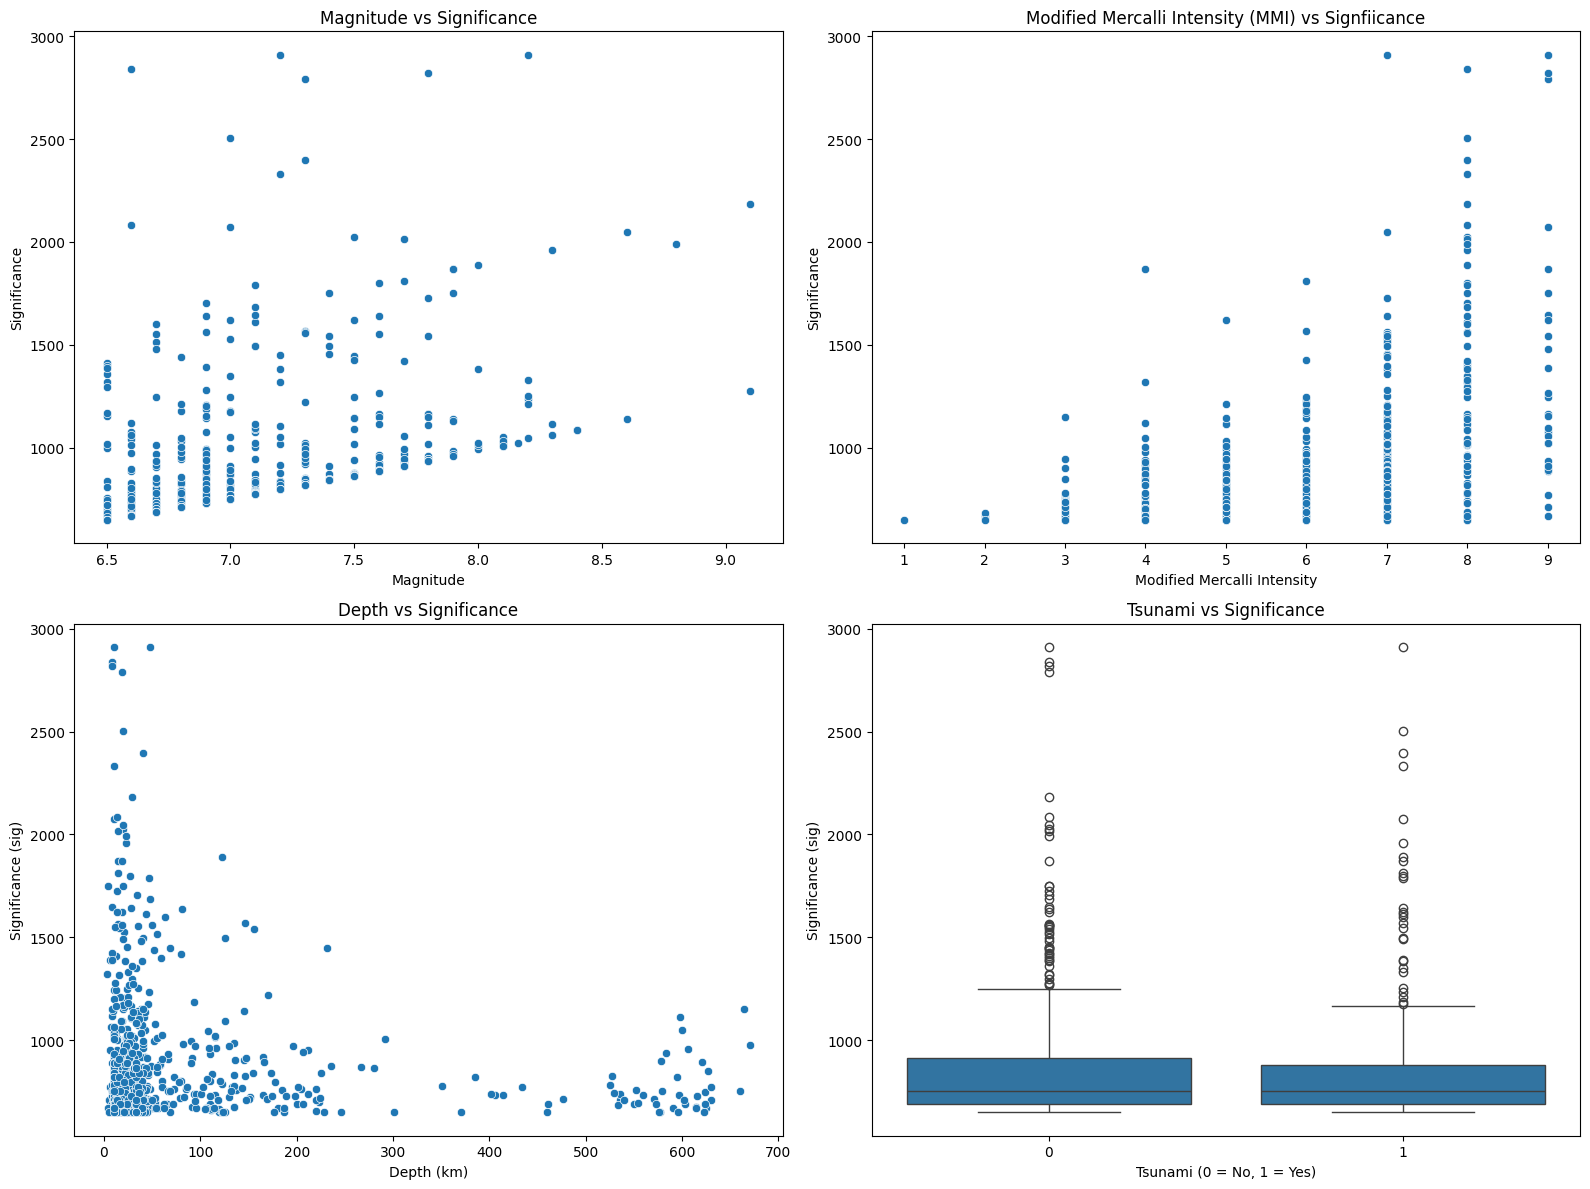

In [21]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(data = earthquake_data_filtered, x = 'magnitude', y = 'sig')
plt.title('Magnitude vs Significance')
plt.xlabel('Magnitude')
plt.ylabel('Significance')

plt.subplot(2, 2, 2)
sns.scatterplot(data = earthquake_data_filtered, x = 'mmi', y = 'sig')
plt.title('Modified Mercalli Intensity (MMI) vs Signfiicance')
plt.xlabel('Modified Mercalli Intensity')
plt.ylabel('Significance')

plt.subplot(2, 2, 3)
sns.scatterplot(data = earthquake_data_filtered, x='depth', y='sig')
plt.title('Depth vs Significance')
plt.xlabel('Depth (km)')
plt.ylabel('Significance (sig)')

plt.subplot(2, 2, 4)
sns.boxplot(data = earthquake_data_filtered, x='tsunami', y='sig')
plt.title('Tsunami vs Significance')
plt.xlabel('Tsunami (0 = No, 1 = Yes)')
plt.ylabel('Significance (sig)')

plt.tight_layout()
plt.show()



### **Preliminary Analysis of Graphs**

#### **1. Magnitude vs Significance (Top Left)**  
**Purpose:**  
Explore how earthquake magnitude affects the significance (sig) of an event.

**Observations:**  
Most earthquakes have magnitudes between 6.5 and 8.0.
No strong linear pattern is observed, but higher magnitudes tend to have slightly higher significance scores.
There is a wide spread in sig values for each magnitude, indicating that magnitude alone does not fully explain earthquake impact.

#### **2. Modified Mercalli Intensity (MMI) vs Significance (Top Right)**  
**Purpose:** Examine whether perceived shaking intensity (mmi) influences significance (sig).

**Observations:**
Higher MMI values (e.g., 7–9) generally correspond to higher significance scores, showing a positive relationship.
The discrete nature of mmi levels (integer values) results in clusters rather than a continuous trend.
Higher MMI values are less frequent but show more extreme sig values, suggesting severe shaking events tend to be more impactful.

#### **3. Depth vs Significance (Bottom Left)**  
**Purpose:**  
Investigate how earthquake depth relates to significance (sig).

**Observations:**  
Most earthquakes occur at shallower depths (0–100 km), where significance tends to be higher.
Deeper earthquakes (>300 km) generally have lower significance, with a few exceptions.
This suggests that shallow earthquakes may have a greater surface impact, contributing to higher significance scores.

#### **4. Tsunami vs Significance (Bottom Right)**  
**Purpose:**  
Assess the influence of tsunami occurrence (0 = No, 1 = Yes) on significance (sig).

**Observations:**  
The boxplots for both categories are similar, indicating tsunami occurrence may not strongly influence the sig variable. However, both categories show outliers with higher sig values, suggesting that some tsunami-related events may still have extreme impacts. Further analysis may be needed to disentangle tsunami effects from other variables like location and magnitude.

---

### **Check for Multicollinary**

In this dataset, the 2 variables: mmi (maximum shaking intensity), magnitude (earthquake magnitude) are directly related to each other as they both indicate how violent an earthquake is. Intuitively, it is plausible to believe that as magnitude of an earthquake increases, so will its shaking intensity, which means that they could be directly related/correlated with each other. So we decided to examine whether or not a problem of multicollinearity exists by computing the Variance Inflation Factor (VIF) across all continuous covariates (mmi, magnitude, depth) to determine if any of them should be removed based on the commonly used VIF threshold of being > 10. 

Mathematically, the VIF is computed by the following formula: 

$$
\text{VIF} = \frac{1}{1 - R_x^2}
$$

where $R_x^2$ is the squared correlation when treating the covariate in question as the response, while treating the remaining covariates as the explanatory variables. A $R_x^2$ close to 1 indicates that covariate in question is highly/almost perfectly correlated with the other ones, resulting in a very high VIF. The VIF of all the covariates are computed below. 

In our dataset, the variables such as mmi (maximum shaking intensity), magnitude, and depth are not centered around zero, as they represent positive values with varied scales. To ensure accurate statistical analysis, we included a constant (intercept) in our calculations. The constant should account for baseline shifts and prevent the regression model from being forced through the origin, which could lead to a biased coefficient estimates and misrepresent relationships between variables. Furthermore, adding a constant improves the reliability of Variance Inflation Factor (VIF) values by properly adjusting for mean differences and shared variance among predictors, allowing us to accurately assess multicollinearity. 

In [22]:
# X = earthquake_data_filtered[['mmi', 'magnitude', 'depth']]
# vif_data = pd.DataFrame()
# vif_data['Variable'] = X.columns
# vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print(vif_data)

from statsmodels.tools import add_constant

# Add a constant/intercept explicitly
X = add_constant(earthquake_data_filtered[['mmi', 'magnitude', 'depth']])

# Compute VIF again
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)



    Variable         VIF
0      const  244.223394
1        mmi    1.527069
2  magnitude    1.139563
3      depth    1.403870


#### Based on the VIF results:

All variables (mmi, magnitude, and depth) have VIF that is < 10, which is considered acceptable and suggests no significant multicollinearity.
These variables can all be included in the regression model without concerns about redundancy or instability of caused by correlations. 

---

### **Perform a 2-sample t-test for the tsunami categorical covariate**

Judging by the boxplot for the tsunami categorical variable above, its seems like an earthquake that generated a tsunami did not significanly cause more damage than an earthquake that did not. However, more information is needed to verify the observation. Therefore, we will perform an 2 sample independent t-test to determine whether or we should accept the above claim that tsuanami does not significantly cause more damage. We will perform this at a 5% significance level, or in other words, significance level = 0.05.

**Formula the hypothesis:** 

$\mu_0$ = mean significance score for earthquakes that did not generate tsunami. <br>
$\mu_1$ = mean significance score for earthquakes that did generate tsunami.

$H_0$: $\mu_0 = \mu_1$ <br> $H_1$: $\mu_0 \neq \mu_1$, 

**Determine the values of the sample statistics:**

We define the following variables which we will compute in the below cell: <br>

$n_0$ = number of earthquakes that did not generate tsunami <br>
$n_1$ = number of earthquakes that did generate tsunami

$s_0$ = standard error of earthquakes that did not generate tsunami <br>
$s_1$ = standard error of earthquakes that did generate tsunami

$\bar{x}_0$ = observed average significance score for earthquakes that did not generate a tsunami <br>
$\bar{x}_1$ = observed average significance score for earthquakes that generated a tsunami

In [23]:
# compute the value of n_0 and n_1
n_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0].shape[0]
n_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1].shape[0]
print("n_0 = " + str(n_0))
print("n_1 = " + str(n_1))

# compute the value of s_0 and s_1
s_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0]['sig'].std().round(2)
s_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1]['sig'].std().round(2)
print("s_0 = " + str(s_0))
print("s_1 = " + str(s_1))

# compute the value of xbar_0 and xbar_1
xbar_0 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 0]['sig'].mean().round(2)
xbar_1 = earthquake_data_filtered[earthquake_data_filtered['tsunami'] == 1]['sig'].mean().round(2)
print("xbar_0 = " + str(xbar_0))
print("xbar_1 = " + str(xbar_1))

# compute the degrees of freedom
df = pow(pow(s_0, 2)/n_0 + pow(s_1, 2)/n_1, 2)/(pow((pow(s_0, 2)/n_0), 2)/(n_0 - 1) + pow((pow(s_1, 2)/n_1), 2)/(n_1 - 1))
print("df = " + str(df.round(2)))


n_0 = 478
n_1 = 304
s_0 = 325.15
s_1 = 318.64
xbar_0 = 874.09
xbar_1 = 863.85
df = 654.79


We have: 

$n_0$ = 478, $n_1$ = 304, $s_0$ = 325.15, $s_1$ = 318.64, $\mu_0$ = 874.09, $\mu_1$ = 863.85

After calculating the statistics above, we can determine the df (degrees of freedom), which is used for our null distribution (t-distribution) for the null model. The df is calculated using the following formula: 

$$
df = \frac{\left( \frac{s_0^2}{n_0} + \frac{s_1^2}{n_1} \right)^2}{\frac{\left( \frac{s_0^2}{n_0} \right)^2}{n_0 - 1} + \frac{\left( \frac{s_1^2}{n_1} \right)^2}{n_1 - 1}}
$$

After plugging the values in, we get a value of around 654.79, so our $df$ = 654. Consequently, our null distrubution would be $t_{654}$.

**Compute the test-statistic:**

The test statistic (t-score) is calculated as follows: 

$$
\text{t-score} = \frac{\bar{x}_0 - \bar{x}_1}{\sqrt{\frac{s_0^2}{n_0}+ \frac{s_1^2}{n_1}}}
$$

which is computed below: 

In [24]:
# Compute the t-score
t_score = (xbar_0 - xbar_1)/math.sqrt(pow(s_0, 2)/n_0 + pow(s_1, 2)/n_1)
print("t-score = " + str(t_score.round(2)))

p_value = 2*(1 - stats.t.cdf(abs(t_score), df))
print("p-value = " + str(p_value.round(2)))

t-score = 0.43
p-value = 0.66


We obtain a t-score = 0.43

**Compute the p-value and state the conclusion of the test**

The P-value obtained from the test is **0.66**, which is much higher than the significance level of 0.05. Therefore, we do not reject $H_0$ in favor of $H_1$ and conclude that earthquakes that generate tsunami's are not more impactful/significant than earthquakes that don't generate tsunami's. Therefore, our kNN regression to predict significance score of a new earthquake will not include the tsunami factor. 

---

## **Create and select a predictive model (kNN regression model)**

### **Pre-test Evaluation of Variables**

Before applying the kNN model, we will explore the distributions of key variables to determine whether transformations, such as log transformations, are necessary. We have noticed that variables with skewed distributions or large ranges may dominate distance calculations, leading to our results having biased predictions. By visualizing the data, identification of patterns, skewness, and outliers that may require scaling or transformation will be done. 

In the following plots, we examine the distributions of magnitude, mmi, and depth to assess their suitability for log transformations or scaling.

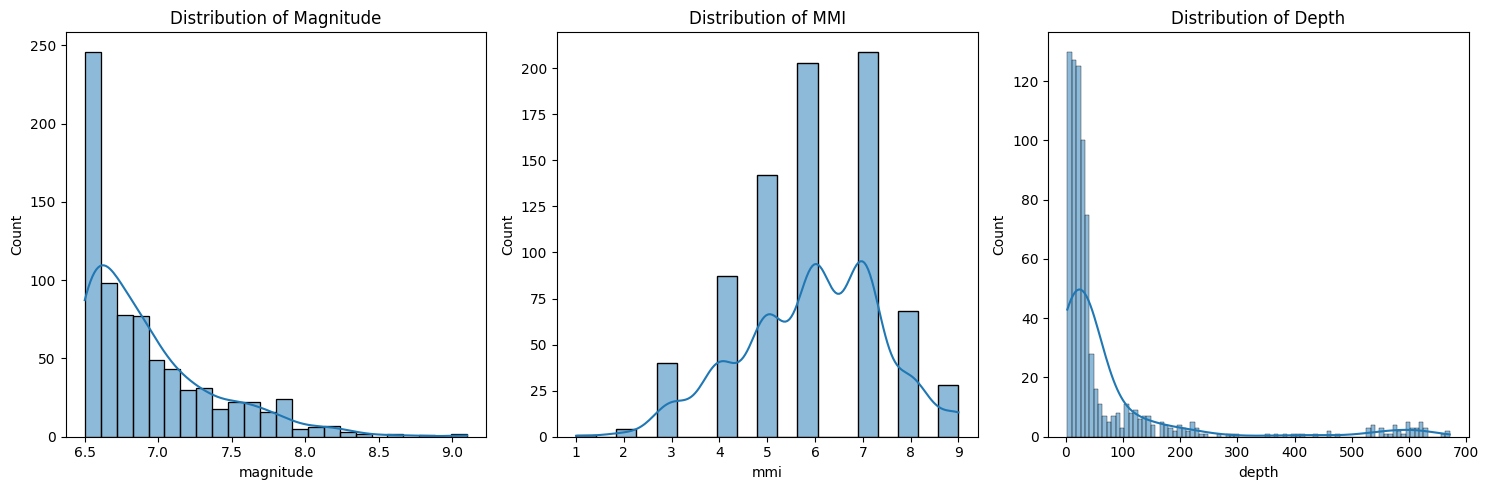

In [61]:
features = ['magnitude', 'mmi', 'depth']
titles = ['Distribution of Magnitude', 'Distribution of MMI', 'Distribution of Depth']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
for i, feature in enumerate(features):
    sns.histplot(earthquake_data_filtered[feature], kde=True, ax=axes[i])  
    axes[i].set_title(titles[i])  
    axes[i].set_xlabel(feature)  
    axes[i].set_ylabel('Count')  

plt.tight_layout()
plt.show()

### **Interpretation of Graphs**

**Magnitude**  
- **Observation:** The **magnitude** variable shows a **right-skewed distribution**, with most values between **6.5 and 7.0** and a **long tail** extending to **9.0**.  
- **Rationale for Transformation:**  
  - The skewness indicates the presence of **outliers** or extreme values that may distort distance calculations in kNN.  
  - a **log transformation** will be applied to compresses the range, reduces skewness, and minimizes the impact of outliers while retaining relative differences.  

**MMI (Maximum Shaking Intensity)**  
- **Observation:** **MMI** displays a **multi-modal pattern** with distinct peaks, resembling a **categorical variable**.  
- **Rationale for Scaling:**  
  - As a discrete ordinal variable, MMI does not require a log transformation.  
  - Instead, **StandardScaler** will be used to standardize the values, ensuring they contribute proportionately to distance calculations.  

**Depth**  
- **Observation:** **Depth** has a **highly right-skewed distribution**, with most earthquakes occurring at **shallow depths (0–100 km)** and a few at extreme depths **up to 700 km**.  
- **Rationale for Transformation:**  
  - The skewness suggests that extreme values may disproportionately affect distance-based calculations.  
  - Applying a **log transformation** reduces skewness and brings outliers closer to the bulk of the data, improving model performance.  


We will use the k-nearest neighbours regression model to predict the how significant an earthquake will be based on the given magnitude, intensity, depth factors. Since we determined that tsunami was not statistically significant in the previous 2-sample hypothesis test, it will not be included in the knn model. 

To select the best k value between 3 and 10, we will test each value of k with a 5-fold cross validation, we choose the k-value with the lowest average MSE. We didn't test k values > 3 because it would likely overfity the data and capture unnecessary noise. Moreover, we also didn't test k values > 10 because it would likely underfit the data, which is not capturing enough noise. 

**The cross validation goes as follows:**

1. Split the data into $n = 5$ groups.
2. Select one group to be the test set, while all other groups are the training set. This is the first fold.  
3. Predict the points in the test set from the points in the training set. In other words, use the points in the training set as the neighbors to make predictions based on the covariate values of the points in 
4. Calculate the MSE, or mean square error, which is a measure of the average residual of each each kNN model can be computed using the formula: 
$$
\text{MSE} = \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y}_i)^2 
$$ 
where $n = 5$, since we are splitting the data in 5 equally sized groups, $y_i$ is the actual value of the response in the test set, and $\hat{y}_i$ is the predicted response from the kNN model in the training set.

5. Repeat steps 2-5, but choosing a new group to be the test set. Repeat until all 5 groups have been the the test set at least once. 
6. Calculate the average MSE of all the folds, using the formula:
$$
\text{average MSE} = \frac{1}{n} \sum_{i = 1}^{n} MSE_i
$$
Once again, $n = 5$ because there are 5 groups, so a total of 5 folds will be performed in total.

Perform the cross validation for all values of k between 3 and 10 (inclusively), and choose the value of k with the lowest average MSE.

In [62]:
# But the values in the data frame into a usable array and set up a set to accumulate the average mse
covariates = earthquake_data_filtered[['magnitude', 'mmi', 'depth']].values
response = earthquake_data_filtered[['sig']].values

avg_mse = {}

# Initialize the 5 fold cross validation by randomly splitting the dataset into groups of 5
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Use for loop to iteratively perform the 5-fold cross validation for different values of k
for k in range(3, 11):
   fold_mse = []
   for train_index, test_index in folds.split(covariates):
      # Split the data into training and test sets for this fold
      covariates_train, covariates_test = covariates[train_index], covariates[test_index]
      response_train, response_test = response[train_index], response[test_index]

      # Initialize kNN regressor with the current k value
      knn = KNeighborsRegressor(n_neighbors=k)

      # Train the model on the training data
      knn.fit(covariates_train, response_train)

      # Predict on the test data
      response_pred = knn.predict(covariates_test)

      # Calculate the MSE for this fold
      mse = mean_squared_error(response_test, response_pred)
        
      # Append the MSE to the list for this fold
      fold_mse.append(mse)

   # Calculate the average MSE across all folds
   avg_mse[k] = np.mean(fold_mse)

# Print out the average mse for all k values
for key, value in avg_mse.items():
   print("k = " + str(key) + ", avg. MSE = " + str(value.round(2)))




k = 3, avg. MSE = 86797.02
k = 4, avg. MSE = 82092.3
k = 5, avg. MSE = 80001.35
k = 6, avg. MSE = 80718.74
k = 7, avg. MSE = 79753.17
k = 8, avg. MSE = 76978.85
k = 9, avg. MSE = 77540.02
k = 10, avg. MSE = 78359.24


**Interpreting Results from the 5-fold cross validation:**

After calculating the average MSE for all values of k from the cross validation, we see that k = 8 seems to most accurately predict the significance score (or impactfulness) of an earthquake from its given magnitude, shaking intensity and depth. 

**Example:**

Let's predict the significance score of an average 7.0 magnitude earthquake with shaking intensity (mmi) at level 6 and at a depth of 40 km. 

In [26]:
optimal_k = 8 # Based on cross validation

# Initialize the 
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)

# Train the kNN model on the entire dataset this time
knn_optimal.fit(covariates, response)

# Predict the significance score
prediction = knn_optimal.predict(np.array([[7, 6, 40]]))

# Print out the predicted significance score
print("Predicted significance score: " + str(prediction[0, 0].round(2)))



Predicted significance score: 777.62


Based on our model, our predicted significance score is 895.5. Examining the dataset obtained, we noticed that most recorded earthquakes were around a 6.5-7.0 magnitude, had a shaking intensity of around level 5-6, depth of around 40 km to have a significance score of about 800. Therefore, the predicted value of 777.62 aligns with the overall trend of the earthquake dataset. 

---

## **Results and discussion**

### **Key Findings**

#### **Multicollinearity Analysis**

The **Variance Inflation Factor (VIF)** analysis was updated to account for a constant (intercept) in the calculations. Including the constant helps to prevent regression models from being forced through the origin, avoiding biased coefficient estimates and misrepresentations of relationships among variables.

**Updated VIF values:**

- **mmi**: 1.53
- **magnitude**: 1.14
- **depth**: 1.40
- **constant**: 244.22

The constant's high VIF value is expected and does not indicate multicollinearity issues, as it merely reflects the intercept's scale. The low VIF values for predictors suggest that multicollinearity is no longer a significant concern, supporting the use of these variables in the modeling process.

#### **Hypothesis Testing on Tsunami Impact**

A **2-sample t-test** was conducted to assess whether earthquakes that generated tsunamis were more impactful than those that did not.

**Results:**

- **t-score = 0.43**
- **p-value = 0.66**

Given that the p-value exceeded the **0.05 significance threshold**, the null hypothesis (Θ0) could not be rejected. This outcome implies that the occurrence of a tsunami does not significantly influence the impactfulness (significance score) of earthquakes. Consequently, the 'tsunami' variable was excluded from the predictive modeling process.

#### **k-Nearest Neighbors (kNN) Regression Model**

A **kNN regression model** was employed to predict earthquake significance scores using 'magnitude,' 'mmi,' and 'depth.' Cross-validation was performed using **k-values ranging from 3 to 10**, with **k = 8** emerging as the optimal choice based on the lowest **Mean Squared Error (MSE = 76978.85)**.

The model demonstrated reasonable predictive performance, aligning well with observed trends in the dataset.

#### **Model Evaluation**

To assess the model’s performance, we evaluated the **Root Mean Squared Error (RMSE)**, which was approximately **277.37**. RMSE provides an interpretable measure of average prediction error, expressed in the same units as the response variable ('sig').

Given that 'sig' values range roughly between **670 and 912**, the RMSE accounts for **30–40% of the response values**. This indicates that the model has **moderate predictive performance** but leaves room for improvement.

---

### **Limitations**

#### **Multicollinearity Concerns**

The inclusion of a constant resolved initial multicollinearity concerns, and the updated VIF values confirmed that predictors were appropriately independent. However, future studies could still explore dimensionality reduction techniques, such as **Principal Component Analysis (PCA)**, for further validation.

#### **Model Assumptions**

The **kNN regression model** relies on locally linear relationships and may be less effective for capturing complex nonlinear patterns. Future analyses might benefit from employing advanced algorithms such as **Decision Trees, Random Forests, or Neural Networks**.

#### **Limited Features**

The current model focused on a limited set of predictors, potentially overlooking other influential factors, such as **geological attributes, population density, and proximity to fault lines**. Incorporating additional features could improve prediction accuracy.

#### **Dataset Size Constraints**

With only **782 observations**, the dataset may not fully represent earthquake events globally, limiting the generalizability of the results. Expanding the dataset could enhance model robustness.

---

### **Recommendations for Future Work**

#### **Feature Engineering**

Introducing additional features, such as **fault line proximity, aftershock frequency, and soil conditions**, could provide deeper insights and improve predictive performance.

#### **Model Enhancements**

Exploring ensemble methods like **Random Forests, Gradient Boosting, and Neural Networks** may yield more accurate predictions by capturing complex relationships within the data.

#### **Visualization Improvements**

Leveraging **Power BI** for interactive dashboards, **geospatial visualizations**, and **time-series animations** could improve data presentation and enhance decision-making processes.

#### **Time-Series Analysis**

Analyzing temporal patterns in earthquake activity could reveal trends and cycles, enabling better forecasting of earthquake risks.

---

## **Final Conclusion**

This study examined earthquake data to evaluate impactfulness based on **magnitude**, **intensity (mmi)**, and **depth**. The analysis revealed several key insights:

- Multicollinearity concerns were resolved through the inclusion of a constant, ensuring reliable predictor relationships.
- Tsunami generation was not found to significantly affect impactfulness.
- A **kNN regression model** with **k = 8** effectively predicted earthquake significance scores, demonstrating alignment with dataset trends.
- Model evaluation using **RMSE = 277.37** suggests **moderate predictive performance**, with opportunities for improvement.
- An RMSE of 277.37 implies that, on average, predictions deviate by about 277.37 units from the actual 'sig' values.

Overall, the findings highlight the importance of carefully selecting predictors and emphasize opportunities for improvement through **advanced algorithms, feature engineering, and visualization tools**. Future work could refine these approaches further to enhance **earthquake risk assessment** and **disaster preparedness strategies**.

